# MaxQuant (MQ) Output-Files

Files compared:
1. `Summary.txt`
2. `mqpar.xml`
3. `peptides.txt`
4. `proteins.txt`

There is are many files more, where several files seem to be available in several times in different formats.

In [1]:
import os
from pathlib import Path

import pandas as pd
import ipywidgets as widgets

FILEPATH_UTILS = 'src/file_utils.py'
FOLDER_DATA = 'data'

os.makedirs(os.path.dirname(FILEPATH_UTILS), exist_ok=True)

In [2]:
# # Recursive solution (in progress)

# def search_subfolders(path='.', depth : int=1):
#     """Search subfolders relative to given path."""
#     if not isinstance(depth, int) and depth>0:
#         raise ValueError(f"Please provide an strictly positive integer, not {depth}")
        
#     path = Path(path)
#     directories = [path]
    
#     def get_subfolders(path, count=0):
#         paths = [x for x in path.iterdir() if x.is_dir()]
#         if count<depth and paths:
#             return paths + [get_subfolders(x, count+1) for x in paths]
#         else:
#             print(paths)
#             return paths
    
#     directories += get_subfolders(path)
#     return directories

# folders = search_subfolders(path='data', depth=3)
# folders

In [3]:
def search_subfolders(path='.', depth : int=1):
    """Search subfolders relative to given path."""
    if not isinstance(depth, int) and depth>0:
        raise ValueError(f"Please provide an strictly positive integer, not {depth}")
        
    path = Path(path)
    directories = [path]
    def get_subfolders(path):
        return [x for x in path.iterdir() if x.is_dir()]
    
    directories_previous = directories.copy()
    while depth > 0:
        directories_new = list()
        for p in directories_previous:
            directories_new.extend(
                get_subfolders(p))
        directories.extend(directories_new)
        directories_previous = directories_new.copy()
        depth -= 1
    return directories

folders= search_subfolders(path='data', depth=2)
w_folder = widgets.Dropdown(options=folders, index=3, description='Select a folder')
w_folder

Dropdown(description='Select a folder', index=3, options=(WindowsPath('data'), WindowsPath('data/denoms'), Win…

In [4]:
%%writefile $FILEPATH_UTILS

import os
from pathlib import Path
import logging

logger = logging.getLogger('root')

from tqdm import tqdm
import pandas as pd
from pandas.errors import EmptyDataError
import ipywidgets as widgets

def check_for_key(iterable, key):
    hits = [x for x in iterable if key in x]
    n_hits = len(hits)
    if n_hits == 1:
        return hits[0]
    elif n_hits == 0:
        return 0
    elif n_hits > 1:
        return '_'.join(iterable)
    
def search_files(path='.', query='.txt'):
    path = Path(path)
    files= []
    for p in path.rglob("*"):
         if query in p.name:
            files.append(str(p.relative_to('.')))
    return files


def process_files(handler_fct, filepaths, key='QE'):
    """Process a list of filepaths using a `handler_fct`.
    `Handler_fct`s have to return a `pandas.DataFrame`.
    
    handle_fct: function
        Function returning a DataFrame for a filepath from `filepaths`
    filepaths: Iterable
        List, tuple, etc. containing filepath to iteratore over.
    """
    names = []
    failed = []
    for i, _file in enumerate(tqdm(filepaths)):
        if i == 0:
            # locals()
            df = handler_fct(_file) # throws an error if the first file cannot be read-in
            names.append(check_for_key(iterable=_file.split(os.sep), key=key))
        else:
            try:
                df = df.join(handler_fct(_file), how='outer', rsuffix=i)
                names.append(check_for_key(iterable=_file.split(os.sep), key=key))
            except EmptyDataError:
                logger.warning('Empty DataFrame: {}'.format(_file))
                failed.append(_file)
    return df, names, failed


def load_summary(filepath:str='summary.txt')-> pd.DataFrame:
    """Load MaxQuant summary.txt file"""
    df = pd.read_table(filepath)
    df = df.T
    df = df.iloc[:,:-1]
    return df

import xmltodict
def load_mqpar_xml(filepath):
    """Load mqpar.xml file. Stores parameters of a MaxQuant run, including version numbers."""
    with open(filepath) as f:
        _ = f.readline()
        xml = f.read()
        return pd.DataFrame(xmltodict.parse(xml))

from numpy import dtype
types_peptides = {'N-term cleavage window': dtype('O'),
 'C-term cleavage window': dtype('O'),
 'Amino acid before': dtype('O'),
 'First amino acid': dtype('O'),
 'Second amino acid': dtype('O'),
 'Second last amino acid': dtype('O'),
 'Last amino acid': dtype('O'),
 'Amino acid after': dtype('O'),
 'A Count': dtype('int64'),
 'R Count': dtype('int64'),
 'N Count': dtype('int64'),
 'D Count': dtype('int64'),
 'C Count': dtype('int64'),
 'Q Count': dtype('int64'),
 'E Count': dtype('int64'),
 'G Count': dtype('int64'),
 'H Count': dtype('int64'),
 'I Count': dtype('int64'),
 'L Count': dtype('int64'),
 'K Count': dtype('int64'),
 'M Count': dtype('int64'),
 'F Count': dtype('int64'),
 'P Count': dtype('int64'),
 'S Count': dtype('int64'),
 'T Count': dtype('int64'),
 'W Count': dtype('int64'),
 'Y Count': dtype('int64'),
 'V Count': dtype('int64'),
 'U Count': dtype('int64'),
 'O Count': dtype('int64'),
 'Length': dtype('int64'),
 'Missed cleavages': dtype('int64'),
 'Mass': dtype('float64'),
 'Proteins': dtype('O'),
 'Leading razor protein': dtype('O'),
 'Start position': dtype('float64'),
 'End position': dtype('float64'),
 'Gene names': dtype('O'),
 'Protein names': dtype('O'),
 'Unique (Groups)': dtype('O'),
 'Unique (Proteins)': dtype('O'),
 'Charges': dtype('O'),
 'PEP': dtype('float64'),
 'Score': dtype('float64'),
 'Intensity': dtype('int64'),
 'Reverse': dtype('O'),
 'Potential contaminant': dtype('O'),
 'id': dtype('int64'),
 'Protein group IDs': dtype('O'),
 'Mod. peptide IDs': dtype('O'),
 'Evidence IDs': dtype('O'),
 'MS/MS IDs': dtype('O'),
 'Best MS/MS': dtype('float64'),
 'Oxidation (M) site IDs': dtype('O'),
 'MS/MS Count': dtype('int64')}

def load_peptide_intensities(filepath):
    """Load Intensities from `peptides.txt`."""
    df = pd.read_table(filepath, index_col='Sequence', dtype=types_peptides)
    return df[['Intensity']]

dtypes_proteins = {'Protein IDs': dtype('O'),
 'Majority protein IDs': dtype('O'),
 'Peptide counts (all)': dtype('O'),
 'Peptide counts (razor+unique)': dtype('O'),
 'Peptide counts (unique)': dtype('O'),
 'Protein names': dtype('O'),
 'Gene names': dtype('O'),
 'Fasta headers': dtype('O'),
 'Number of proteins': dtype('int64'),
 'Peptides': dtype('int64'),
 'Razor + unique peptides': dtype('int64'),
 'Unique peptides': dtype('int64'),
 'Sequence coverage [%]': dtype('float64'),
 'Unique + razor sequence coverage [%]': dtype('float64'),
 'Unique sequence coverage [%]': dtype('float64'),
 'Mol. weight [kDa]': dtype('float64'),
 'Sequence length': dtype('int64'),
 'Sequence lengths': dtype('O'),
 'Q-value': dtype('float64'),
 'Score': dtype('float64'),
 'Intensity': dtype('int64'),
 'MS/MS count': dtype('int64'),
 'Only identified by site': dtype('O'),
 'Reverse': dtype('O'),
 'Potential contaminant': dtype('O'),
 'id': dtype('int64'),
 'Peptide IDs': dtype('O'),
 'Peptide is razor': dtype('O'),
 'Mod. peptide IDs': dtype('O'),
 'Evidence IDs': dtype('O'),
 'MS/MS IDs': dtype('O'),
 'Best MS/MS': dtype('O'),
 'Oxidation (M) site IDs': dtype('O'),
 'Oxidation (M) site positions': dtype('O'),
 'Taxonomy IDs': dtype('O')}
    
def load_protein_intensities(filepath):
    """Load Intensities from `proteins.txt`."""
    df = pd.read_table(filepath, index_col='Majority protein IDs', dtype=dtypes_proteins)
    return df[['Intensity']]

Overwriting src/file_utils.py


Reimport files (could be moved to a package at some point)

In [5]:
import src.file_utils as file_io
from src.file_utils import search_files, check_for_key
from src.file_utils import process_files
from src.file_utils import load_summary, load_mqpar_xml, load_peptide_intensities, load_protein_intensities

All Text based Files in the selected folder:

In [6]:
paths_summaries = search_files(path=w_folder.value, query='.txt')
w_file = widgets.Dropdown(options=paths_summaries, description='Select a file')
w_file

Dropdown(description='Select a file', options=('data\\denoms\\data\\hela\\20190103_QE8_nLC0_LiNi_QC_MNT_15cm_H…

## MQ Summary files

In [7]:
paths_summaries = search_files(path=w_folder.value, query='summary.txt')
w_file = widgets.Dropdown(options=paths_summaries, description='View files')
w_file

Dropdown(description='View files', options=('data\\denoms\\data\\hela\\MQ1.6.0.1_20190103_QE8_nLC0_LiNi_QC_MNT…

### File Handler

In [8]:
load_summary??

Signature: load_summary(filepath: str = 'summary.txt') -> pandas.core.frame.DataFrame
Source:   
def load_summary(filepath:str='summary.txt')-> pd.DataFrame:
    """Load MaxQuant summary.txt file"""
    df = pd.read_table(filepath)
    df = df.T
    df = df.iloc[:,:-1]
    return df
File:      c:\users\kzl465\documents\vaep\project\src\file_utils.py
Type:      function


### Summaries

In [9]:
df, names, failed = process_files(handler_fct=load_summary, filepaths=paths_summaries)
df.columns = names
df

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 103.81it/s]


,MQ1.6.0.1_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_200327,MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_200330,MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_20190104110509_200331,MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_02_200331
Av. Absolute Mass Deviation [mDa],0.62535,0.63438,0.56985,0.5985
Av. Absolute Mass Deviation [ppm],0.88479,0.90027,0.78262,0.82919
Enzyme,Trypsin/P,Trypsin/P,Trypsin/P,Trypsin/P
Enzyme first search,NaN,NaN,NaN,NaN
Enzyme mode,Specific,Specific,Specific,Specific
Enzyme mode first search,NaN,NaN,NaN,NaN
Fixed modifications,Carbamidomethyl (C),NaN,Carbamidomethyl (C),Carbamidomethyl (C)
Isotope Patterns,181553,188577,228606,193186
Isotope Patterns Repeatedly Sequenced,12902,12923,9687,12155
Isotope Patterns Repeatedly Sequenced [%],16,15.91,10,14


## MaxQuant Parameter File

In [10]:
paths_parameters = search_files(path=w_folder.value, query='mqpar.xml')
w_file = widgets.Dropdown(options=paths_parameters, description='Select a file')
w_file

Dropdown(description='Select a file', options=('data\\denoms\\data\\hela\\MQ1.6.0.1_20190103_QE8_nLC0_LiNi_QC_…

### Parameter Files

In [11]:
load_mqpar_xml??

Signature: load_mqpar_xml(filepath)
Source:   
def load_mqpar_xml(filepath):
    """Load mqpar.xml file. Stores parameters of a MaxQuant run, including version numbers."""
    with open(filepath) as f:
        _ = f.readline()
        xml = f.read()
        return pd.DataFrame(xmltodict.parse(xml))
File:      c:\users\kzl465\documents\vaep\project\src\file_utils.py
Type:      function


In [12]:
df, col_names, failed = process_files(handler_fct=load_mqpar_xml, filepaths=paths_parameters) 
df.columns = col_names
pd.set_option('max_rows', 160)
df

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 173.95it/s]


,MQ1.6.0.1_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_200327,MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_200330,MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_20190104110509_200331,MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_02_200331
@aifCorrelation,0,NaN,NaN,NaN
@aifCorrelationFirstPass,0,NaN,NaN,NaN
@aifIsoWeight,0,NaN,NaN,NaN
@aifIterative,false,NaN,NaN,NaN
@aifMinMass,0,NaN,NaN,NaN
@aifMsmsTol,0,NaN,NaN,NaN
@aifSecondPass,false,NaN,NaN,NaN
@aifSilWeight,0,NaN,NaN,NaN
@aifThresholdFdr,0,NaN,NaN,NaN
@aifTopx,0,NaN,NaN,NaN


## Peptides

In [13]:
paths_peptides = search_files(path=w_folder.value, query='peptides.txt')
paths_peptides

['data\\denoms\\data\\hela\\20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_20190104110509_peptides.txt',
 'data\\denoms\\data\\hela\\20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_peptides.txt',
 'data\\denoms\\data\\hela\\20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_02_peptides.txt',
 'data\\denoms\\data\\hela\\MQ1.6.0.1_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_200327\\combined\\txt\\peptides.txt',
 'data\\denoms\\data\\hela\\MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_200330\\combined\\txt\\peptides.txt',
 'data\\denoms\\data\\hela\\MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_20190104110509_200331\\combined\\txt\\peptides.txt',
 'data\\denoms\\data\\hela\\MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_02_200331\\combined\\txt\\peptides.txt']

In [14]:
df = pd.read_table(paths_peptides[1], index_col='Sequence')
pd.set_option('max_columns', 60)
# types = dict(df.dtypes)
df

,N-term cleavage window,C-term cleavage window,Amino acid before,First amino acid,Second amino acid,Second last amino acid,Last amino acid,Amino acid after,A Count,R Count,N Count,D Count,C Count,Q Count,E Count,G Count,H Count,I Count,L Count,K Count,M Count,F Count,P Count,S Count,T Count,W Count,Y Count,V Count,U Count,O Count,Length,Missed cleavages,Mass,Proteins,Leading razor protein,Start position,End position,Gene names,Protein names,Unique (Groups),Unique (Proteins),Charges,PEP,Score,Experiment 20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01.raw,Intensity,Intensity 20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01.raw,Reverse,Potential contaminant,id,Protein group IDs,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,MS/MS Count
Sequence,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAAAAAAAAPAAAATAPTTAATTAATAAQ,GLKKRDKKNKTKKTKAAAAAAAAAPAAAAT,TAPTTAATTAATAAQ_______________,K,A,A,A,Q,-,20,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,6,0,0,0,0,0,29,0,2367.20300,P37108;H0YLW0,P37108,108.0,136.0,SRP14,Signal recognition particle 14 kDa protein,yes,no,3,1.113600e-03,23.790,1.0,908220000,908220000,NaN,NaN,0,1659,0,0,0,0.0,NaN,1
AAAAAAALQAK,TILRQARNHKLRVDKAAAAAAALQAKSDEK,RVDKAAAAAAALQAKSDEKAAVAGKKPVVG,K,A,A,A,K,S,8,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,11,0,955.54508,P36578;H3BM89;H3BU31,P36578,354.0,364.0,RPL4,60S ribosomal protein L4,yes,no,2,2.580900e-02,28.174,1.0,2652100000,2652100000,NaN,NaN,1,1654,1,1,1,1.0,NaN,1
AAAAAAGAASGLPGPVAQGLK,______________________________,GAASGLPGPVAQGLKEALVDTLTGILSPVQ,M,A,A,L,K,E,9,0,0,0,0,1,0,4,0,0,2,1,0,0,2,1,0,0,0,1,0,0,21,0,1747.95810,Q96P70,Q96P70,2.0,22.0,IPO9,Importin-9,yes,yes,2,7.747900e-05,57.836,1.0,111990000,111990000,NaN,NaN,2,2578,2,2,2,2.0,NaN,1
AAAAAAGAGPEMVR,______________________________,MAAAAAAGAGPEMVRGQVFDVGPRYTNLSY,M,A,A,V,R,G,7,1,0,0,0,0,1,2,0,0,0,0,1,0,1,0,0,0,0,1,0,0,14,0,1241.61870,P28482-2;P28482,P28482-2,2.0,15.0,MAPK1,Mitogen-activated protein kinase 1,yes,no,2,1.694400e-05,78.655,1.0,39016000,39016000,NaN,NaN,3,1587,3,3,3,3.0,NaN,1
AAAAAAVGPGAGGAGSAVPGGAGPCATVSVFPGAR,______________________________,GAGPCATVSVFPGARLLTIGDANGEIQRHA,M,A,A,A,R,L,12,1,0,0,1,0,0,9,0,0,0,0,0,1,4,2,1,0,0,4,0,0,35,0,2906.44570,Q86X55-2;Q86X55-1;Q86X55;K7EK20;K7EPK1,Q86X55-2,2.0,36.0,CARM1,Histone-arginine methyltransferase CARM1,yes,no,3,4.430900e-20,67.283,1.0,76996000,76996000,NaN,NaN,4,2368,4,4,4,4.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YYTPTISR,AHGYGAFLTLSILDRYYTPTISRERAVELL,TLSILDRYYTPTISRERAVELLRKCLEELQ,R,Y,Y,S,R,E,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,2,0,2,0,0,0,8,0,999.50255,P49721;A0A087WVV1,P49721,146.0,153.0,PSMB2,Proteasome subunit beta type-2,yes,no,2,1.074400e-02,63.565,1.0,60341000,60341000,NaN,NaN,14902,1749,15053,16771,18331,18331.0,NaN,1
YYTPVPCESATAK,IYVFPDRPKDEVYSKYYTPVPCESATAKAV,SKYYTPVPCESATAKAVDGYVKPQIKQVVP,K,Y,Y,A,K,A,2,0,0,0,1,0,1,0,0,0,0,1,0,0,2,1,2,0,2,1,0,0,13,0,1485.68100,P51692,P51692,682.0,694.0,STAT5B,Signal transducer and activator of transcripti...,yes,yes,2,1.674200e-02,26.514,1.0,27435000,27435000,NaN,NaN,14903,1784,15054,16772,18332,18332.0,NaN,1
YYTSASGDEMVSLK,HEDSQNRKKLSELLRYYTSASGDEMVSLKD,RYYTSASGDEMVSLKDYCTRMKENQKHIYY,R,Y,Y,L,K,D,1,0,0,1,0,0,1,1,0,0,1,1,1,0,0,3,1,0,2,1,0,0,14,0,1549.69700,P07900;P07900-2,P07900,465.0,478.0,HSP90AA1,Heat shock protein HSP 90-alpha,yes,no,2,9.779800e-05,72.006,1.0,370960000,370960000,NaN,NaN,14904,1383,15055,16773,18333;18334,18334.0,NaN,2


### File-Handler

In [15]:
load_peptide_intensities??

Signature: load_peptide_intensities(filepath)
Source:   
def load_peptide_intensities(filepath):
    """Load Intensities from `peptides.txt`."""
    df = pd.read_table(filepath, index_col='Sequence', dtype=types_peptides)
    return df[['Intensity']]
File:      c:\users\kzl465\documents\vaep\project\src\file_utils.py
Type:      function


### Load Peptide Intensities

In [16]:
peptides, names, failed = process_files(handler_fct=load_peptide_intensities, filepaths=paths_peptides) 
peptides.columns = names
peptides

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.95it/s]


,20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_20190104110509_peptides.txt,20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_peptides.txt,20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_02_peptides.txt,MQ1.6.0.1_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_200327,MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_200330,MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_20190104110509_200331,MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_02_200331
Sequence,,,,,,,
AAAAAAAAAAAAAAAGAGAGAK,NaN,NaN,NaN,NaN,NaN,NaN,2.074100e+07
AAAAAAAAAPAAAATAPTTAATTAATAAQ,1.221000e+09,9.082200e+08,1.049400e+09,9.862700e+08,9.082200e+08,1.221000e+09,1.049400e+09
AAAAAAAAAVSR,NaN,NaN,4.194800e+07,NaN,NaN,NaN,4.194800e+07
AAAAAAAGDSDSWDADAFSVEDPVRK,1.760000e+08,NaN,NaN,NaN,NaN,1.760000e+08,NaN
AAAAAAALQAK,2.442400e+09,2.652100e+09,NaN,2.652100e+09,2.652100e+09,2.442400e+09,3.149100e+09
...,...,...,...,...,...,...,...
YYTPVPCESATAK,3.114800e+07,2.743500e+07,NaN,2.743500e+07,2.743500e+07,3.114800e+07,3.795500e+07
YYTSASGDEMVSLK,5.241400e+08,3.709600e+08,4.040300e+08,3.709600e+08,3.709600e+08,5.241400e+08,4.033500e+08
YYVTIIDAPGHR,1.167700e+08,4.247000e+08,7.510700e+07,4.247000e+08,4.247000e+08,1.167700e+08,7.510700e+07


In [17]:
peptides.memory_usage(deep=False).sum() / 1000000.0 

2.068608

In [18]:
pd.options.display.float_format = '{:,.0f}'.format
peptides.sort_index(inplace=True)
peptides = peptides.T
peptides

Sequence,AAAAAAAAAAAAAAAGAGAGAK,AAAAAAAAAPAAAATAPTTAATTAATAAQ,AAAAAAAAAVSR,AAAAAAAGDSDSWDADAFSVEDPVRK,AAAAAAALQAK,AAAAAAGAASGLPGPVAQGLK,AAAAAAGAGPEMVR,AAAAAAGEARR,AAAAAAVGPGAGGAGSAVPGGAGPCATVSVFPGAR,AAAAAEQQQFYLLLGNLLSPDNVVR,AAAAAEQQQFYLLLGNLLSPDNVVRK,AAAAAGTATSQRFFQSFSDALIDEDPQAALEELTK,AAAAAMAEQESAR,AAAAAQGGGGGEPR,AAAAASHLNLDALREVLECPICMESFTEEQLRPK,AAAAASRGVGAK,AAAAATVVPPMVGGPPFVGPVGFGPGDRSHLDSPEAR,AAAAAWEEPSSGNGTAR,AAAAECDVVMAATEPELLDDQEAK,AAAAGAAAAAAAEGEAPAEMGALLLEK,AAAAKPNNLSLVVHGPGDLRLENYPIPEPGPNEVLLR,AAAAMAAAAGGGAGAAR,AAAASVPNADGLK,AAAAVAAAASSCRPLGSGAGPGPTGAAPVSAPAPGPGPAGK,AAAAVQGGR,AAAAVVAAAAR,AAAAVVEFQR,AAAAVVVPAEWIK,AAADGDDSLYPIAVLIDELR,AAADTLQGPMQAAYREAFQSVVLPAFEK,...,YYFYHGLSWPQLSYIAEDENGK,YYGAQTVR,YYGGGSEGGRAPK,YYGHGANSPISTDLFTYLCPALLYQIDSR,YYGLQILENVIK,YYIAASYVK,YYIDADLLR,YYIQNGIQSFMQNYSSIDVLLHQSR,YYLAPKIEDEEGS,YYLCGFCPAELFTNTR,YYNDYGDIIK,YYNSDVHR,YYPTAEEVYGPEVETIVQEEDTQPLTEPIIKPVK,YYPTEDVPRK,YYQTIGNHASYYK,YYRESADPLGAWLQDAR,YYREVLPGEIVEISR,YYRPTEVDFLQGDCTK,YYRVCTLAIIDPGDSDIIR,YYSFFDLNPK,YYSSHYMTLVVQSK,YYSYGLEK,YYTEFPTVLDITAEDPSK,YYTGNYDQYVK,YYTPTISR,YYTPVPCESATAK,YYTSASGDEMVSLK,YYVTIIDAPGHR,YYVTIIDAPGHRDFIK,YYYQGCASWK
20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_20190104110509_peptides.txt,nan,"1,221,000,000",nan,"176,000,000","2,442,400,000","231,780,000","45,597,000","100,090,000",nan,"29,533,000",nan,"97,363,000","32,325,000","80,621,000",nan,"126,870,000","69,843,000","137,560,000","113,040,000","87,615,000",nan,nan,"64,079,000",nan,nan,"20,578,000",nan,nan,nan,nan,...,nan,nan,nan,"44,003,000",nan,nan,nan,"109,110,000","54,078,000","133,310,000","60,311,000","226,760,000",nan,nan,"143,580,000",nan,"56,383,000","45,435,000","1,680,100,000",nan,nan,"114,170,000","112,690,000","108,990,000",nan,"31,148,000","524,140,000","116,770,000","141,250,000","19,077,000"
20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_peptides.txt,nan,"908,220,000",nan,nan,"2,652,100,000","111,990,000","39,016,000",nan,"76,996,000",nan,"677,620,000","29,526,000","22,713,000",nan,nan,"100,100,000","51,173,000",nan,"85,955,000","94,891,000",nan,"10,623,000",nan,"19,582,000",nan,nan,"153,490,000","111,050,000",nan,nan,...,"35,455,000","170,830,000",nan,nan,nan,"52,084,000","16,042,000","22,343,000",nan,"61,005,000",nan,"50,142,000","44,718,000","1,025,800,000",nan,nan,nan,nan,"277,220,000","106,160,000",nan,nan,"86,276,000",nan,"60,341,000","27,435,000","370,960,000","424,700,000","79,719,000",nan
20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_02_peptides.txt,nan,"1,049,400,000","41,948,000",nan,nan,"90,774,000","34,096,000",nan,"65,850,000","36,299,000","1,906,500,000","208,670,000",nan,"36,827,000","39,871,000","107,860,000",nan,"95,578,000","107,220,000",nan,nan,nan,"42,443,000",nan,"142,770,000",nan,"131,390,000","95,755,000","12,416,000","50,565,000",...,"65,639,000","204,740,000","195,570,000",nan,"736,890,000","58,096,000",nan,nan,nan,nan,nan,"183,330,000","40,841,000",nan,"106,270,000","107,710,000","22,992,000",nan,"468,880,000","94,300,000","39,442,000",nan,"81,074,000","78,257,000","61,502,000",nan,"404,030,000","75,107,000",nan,nan
MQ1.6.0.1_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_200327,nan,"986,270,000",nan,nan,"2,652,100,000","111,990,000","39,016,000",nan,"76,996,000",nan,"677,620,000","29,526,000","22,713,000",nan,nan,"100,100,000","51,173,000","65,238,000","85,955,000","94,891,000",nan,"10,623,000","45,255,000",nan,nan,nan,"153,490,000","111,050,000",nan,nan,...,"35,455,000","170,830,000",nan,nan,nan,"52,084,000","16,042,000","22,343,000",nan,"61,005,000",nan,"53,629,000","44,718,000","1,255,100,000",nan,nan,nan,nan,"277,220,000","106,160,000",nan,nan,"86,276,000",nan,"60,341,000","27,435,000","370,960,000","424,700,000","2,132,300,000",nan
MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_200330,nan,"908,220,000",nan,nan,"2,652,100,000","111,990,000","39,016,000",nan,"76,996,000",nan,"677,620,000","29,526,000","22,713,000",nan,nan,"100,100,000","51,173,000",nan,"85,955,000","94,891,000",nan,"10,623,000",nan,"19,582,000",nan,nan,"1

In [19]:
peptides.sort_values(by='AAAAAAAAAPAAAATAPTTAATTAATAAQ')

Sequence,AAAAAAAAAAAAAAAGAGAGAK,AAAAAAAAAPAAAATAPTTAATTAATAAQ,AAAAAAAAAVSR,AAAAAAAGDSDSWDADAFSVEDPVRK,AAAAAAALQAK,AAAAAAGAASGLPGPVAQGLK,AAAAAAGAGPEMVR,AAAAAAGEARR,AAAAAAVGPGAGGAGSAVPGGAGPCATVSVFPGAR,AAAAAEQQQFYLLLGNLLSPDNVVR,AAAAAEQQQFYLLLGNLLSPDNVVRK,AAAAAGTATSQRFFQSFSDALIDEDPQAALEELTK,AAAAAMAEQESAR,AAAAAQGGGGGEPR,AAAAASHLNLDALREVLECPICMESFTEEQLRPK,AAAAASRGVGAK,AAAAATVVPPMVGGPPFVGPVGFGPGDRSHLDSPEAR,AAAAAWEEPSSGNGTAR,AAAAECDVVMAATEPELLDDQEAK,AAAAGAAAAAAAEGEAPAEMGALLLEK,AAAAKPNNLSLVVHGPGDLRLENYPIPEPGPNEVLLR,AAAAMAAAAGGGAGAAR,AAAASVPNADGLK,AAAAVAAAASSCRPLGSGAGPGPTGAAPVSAPAPGPGPAGK,AAAAVQGGR,AAAAVVAAAAR,AAAAVVEFQR,AAAAVVVPAEWIK,AAADGDDSLYPIAVLIDELR,AAADTLQGPMQAAYREAFQSVVLPAFEK,...,YYFYHGLSWPQLSYIAEDENGK,YYGAQTVR,YYGGGSEGGRAPK,YYGHGANSPISTDLFTYLCPALLYQIDSR,YYGLQILENVIK,YYIAASYVK,YYIDADLLR,YYIQNGIQSFMQNYSSIDVLLHQSR,YYLAPKIEDEEGS,YYLCGFCPAELFTNTR,YYNDYGDIIK,YYNSDVHR,YYPTAEEVYGPEVETIVQEEDTQPLTEPIIKPVK,YYPTEDVPRK,YYQTIGNHASYYK,YYRESADPLGAWLQDAR,YYREVLPGEIVEISR,YYRPTEVDFLQGDCTK,YYRVCTLAIIDPGDSDIIR,YYSFFDLNPK,YYSSHYMTLVVQSK,YYSYGLEK,YYTEFPTVLDITAEDPSK,YYTGNYDQYVK,YYTPTISR,YYTPVPCESATAK,YYTSASGDEMVSLK,YYVTIIDAPGHR,YYVTIIDAPGHRDFIK,YYYQGCASWK
20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_peptides.txt,nan,"908,220,000",nan,nan,"2,652,100,000","111,990,000","39,016,000",nan,"76,996,000",nan,"677,620,000","29,526,000","22,713,000",nan,nan,"100,100,000","51,173,000",nan,"85,955,000","94,891,000",nan,"10,623,000",nan,"19,582,000",nan,nan,"153,490,000","111,050,000",nan,nan,...,"35,455,000","170,830,000",nan,nan,nan,"52,084,000","16,042,000","22,343,000",nan,"61,005,000",nan,"50,142,000","44,718,000","1,025,800,000",nan,nan,nan,nan,"277,220,000","106,160,000",nan,nan,"86,276,000",nan,"60,341,000","27,435,000","370,960,000","424,700,000","79,719,000",nan
MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_200330,nan,"908,220,000",nan,nan,"2,652,100,000","111,990,000","39,016,000",nan,"76,996,000",nan,"677,620,000","29,526,000","22,713,000",nan,nan,"100,100,000","51,173,000",nan,"85,955,000","94,891,000",nan,"10,623,000",nan,"19,582,000",nan,nan,"153,490,000","111,050,000",nan,nan,...,"35,455,000","170,830,000",nan,nan,nan,"52,084,000","16,042,000","22,343,000",nan,"61,005,000",nan,"50,142,000","44,718,000","1,025,800,000",nan,nan,nan,nan,"277,220,000","106,160,000",nan,nan,"86,276,000",nan,"60,341,000","27,435,000","370,960,000","424,700,000","79,719,000",nan
MQ1.6.0.1_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_200327,nan,"986,270,000",nan,nan,"2,652,100,000","111,990,000","39,016,000",nan,"76,996,000",nan,"677,620,000","29,526,000","22,713,000",nan,nan,"100,100,000","51,173,000","65,238,000","85,955,000","94,891,000",nan,"10,623,000","45,255,000",nan,nan,nan,"153,490,000","111,050,000",nan,nan,...,"35,455,000","170,830,000",nan,nan,nan,"52,084,000","16,042,000","22,343,000",nan,"61,005,000",nan,"53,629,000","44,718,000","1,255,100,000",nan,nan,nan,nan,"277,220,000","106,160,000",nan,nan,"86,276,000",nan,"60,341,000","27,435,000","370,960,000","424,700,000","2,132,300,000",nan
20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_02_peptides.txt,nan,"1,049,400,000","41,948,000",nan,nan,"90,774,000","34,096,000",nan,"65,850,000","36,299,000","1,906,500,000","208,670,000",nan,"36,827,000","39,871,000","107,860,000",nan,"95,578,000","107,220,000",nan,nan,nan,"42,443,000",nan,"142,770,000",nan,"131,390,000","95,755,000","12,416,000","50,565,000",...,"65,639,000","204,740,000","195,570,000",nan,"736,890,000","58,096,000",nan,nan,nan,nan,nan,"183,330,000","40,841,000",nan,"106,270,000","107,710,000","22,992,000",nan,"468,880,000","94,300,000","39,442,000",nan,"81,074,000","78,257,000","61,502,000",nan,"404,030,000","75,107,000",nan,nan
MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_02_200331,"20,741,000","1,049,400,000","41,948,000",nan,"3,149,100,000","90,774,000","34,096,000",nan,"65,850,000","36,299,000","1,906,500,000","208,670,000",nan,"36,827,000","39,871,000","108,990,000",nan,"95,578,000","101,290,000",nan,"252,610,000",nan,"42,443,000",nan,"142,770,000"

In [20]:
# fpath = os.path.join(FOLDER_DATA, 'peptide_intensities.pkl')
# peptides.to_pickle(fpath)

In [21]:
peptides.isna().sum(axis=0)

Sequence
AAAAAAAAAAAAAAAGAGAGAK           6
AAAAAAAAAPAAAATAPTTAATTAATAAQ    0
AAAAAAAAAVSR                     5
AAAAAAAGDSDSWDADAFSVEDPVRK       5
AAAAAAALQAK                      1
                                ..
YYTPVPCESATAK                    1
YYTSASGDEMVSLK                   0
YYVTIIDAPGHR                     0
YYVTIIDAPGHRDFIK                 2
YYYQGCASWK                       5
Length: 32322, dtype: int64

### Peptide sequences
- average length, max, min, etc.
- overlap

In [22]:
peptides.columns.to_series()

Sequence
AAAAAAAAAAAAAAAGAGAGAK                  AAAAAAAAAAAAAAAGAGAGAK
AAAAAAAAAPAAAATAPTTAATTAATAAQ    AAAAAAAAAPAAAATAPTTAATTAATAAQ
AAAAAAAAAVSR                                      AAAAAAAAAVSR
AAAAAAAGDSDSWDADAFSVEDPVRK          AAAAAAAGDSDSWDADAFSVEDPVRK
AAAAAAALQAK                                        AAAAAAALQAK
                                             ...              
YYTPVPCESATAK                                    YYTPVPCESATAK
YYTSASGDEMVSLK                                  YYTSASGDEMVSLK
YYVTIIDAPGHR                                      YYVTIIDAPGHR
YYVTIIDAPGHRDFIK                              YYVTIIDAPGHRDFIK
YYYQGCASWK                                          YYYQGCASWK
Name: Sequence, Length: 32322, dtype: object

### Comparison between MaxQuant v1.6.0.1 and v1.6.1.12

In [23]:
peptides_1601  = peptides.loc['MQ1.6.0.1_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_200327']
peptides_16112 =  peptides.loc['MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_200330']

In [24]:
mask_diff = peptides_1601 == peptides_16112
mask_diff.sum()

13369

In [25]:
differences = pd.DataFrame([peptides_1601[~mask_diff], peptides_16112[~mask_diff]])
differences = differences.dropna(axis=1, how='all')
differences

Sequence,AAAAAAAAAPAAAATAPTTAATTAATAAQ,AAAAAWEEPSSGNGTAR,AAAASVPNADGLK,AAAAVAAAASSCRPLGSGAGPGPTGAAPVSAPAPGPGPAGK,AAAEVAGQFVIK,AAAMVPGR,AAANFSDR,AAAQLLQSQAQQSGAQQTKK,AAAVAAAGAGEPQSPDELLPK,AADIIDGLRK,AAEGVSAADMAK,AAELIANSLATAGDGLIELRK,AAEPPPPKIPK,AAETQTLNFGPEWLR,AAFGEEVDAVDTGISR,AAFGEEVDAVDTGISRETSSDVALASHILTALREK,AAGALLNGPPQFSTAPEIK,AAGHPGDPESQQR,AAGNESFRNGQYAEASALYGR,AAGPSLSHTSGGTQSK,AAIGCGIVESILNWVK,AAIRDIEGKLPQTEQELK,AALAFGFLDLLK,AALAPELALEIPSGSQADIPLPK,AALETDENLLLCAPTGAGK,AALLDQALSNAR,AALLLLLTFLAK,AALQEEEQASK,AALSALESFLK,AALSSQQQQQLALLLQQFQTLK,...,YRPRAPIIAVTR,YRSDGALLLGASSLSGR,YRVPDVLVADPPIAR,YRYFACLMR,YSELTTVQQQLIR,YSGPEDDAAISLAFSKK,YSHLQPGDHLTDITLK,YSNFVSFPLYLNGR,YSQFINFPIYVWSSK,YSQYQQAIYK,YSSLYAQLCLR,YSVLLPTYNERENLPLIVWLLVK,YSVQLLTPANLLAK,YTHAANTVVYSSNK,YTIIIPENLKPQMK,YTPSGQAGAAASESLFVSNHAY,YTPVQQGPVGVNVTYGGDPIPK,YVANLFPYK,YVIDYYDGGEVNK,YVLNEEMSGLPAARK,YVSSLTEEISK,YVSVCEGPLK,YVVISQGLDKPR,YVYVVTELMK,YWDVPPPGFEHITPMQYK,YWLMLNEK,YYAVNFPMRDGIDDESYGQIFKPIISK,YYNSDVHR,YYPTEDVPRK,YYVTIIDAPGHRDFIK
MQ1.6.0.1_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_200327,"986,270,000","65,238,000","45,255,000",nan,"115,260,000",0,0,"25,638,000","58,700,000","19,616,000","55,652,000","883,790,000",nan,"35,125,000","21,302,000","258,830,000","17,162,000","115,640,000","15,191,000","55,567,000","202,610,000","73,791,000","44,729,000","42,115,000","41,104,000","9,056,700",nan,0,"522,760,000","70,417,000",...,"493,960,000",nan,"492,320,000","13,641,000","13,176,000","30,404,000","123,270,000","115,070,000","563,670,000","96,602,000","18,898,000","49,375,000","448,590,000",nan,nan,"479,420,000","1,251,800,000","13,248,000","41,924,000","22,873,000","228,360,000","26,959,000",nan,"20,289,000","63,441,000",nan,"59,211,000","53,629,000","1,255,100,000","2,132,300,000"
MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_200330,"908,220,000",nan,nan,"19,582,000","97,480,000",nan,"41,156,000",nan,nan,nan,"63,276,000","857,890,000","22,153,000",nan,nan,"260,000,000",nan,"115,190,000",nan,"54,568,000","155,130,000",nan,"43,950,000",nan,nan,nan,"10,419,000","48,325,000","520,450,000","66,985,000",...,nan,"405,190,000","491,070,000",nan,nan,nan,nan,nan,"563,020,000",nan,nan,nan,nan,0,"93,548,000","313,440,000","324,270,000",nan,nan,nan,"229,430,000","27,015,000","14,755,000","21,379,000",nan,"24,430,000",nan,"50,142,000","1,025,800,000","79,719,000"


Amount of _overall_ assigned intensity is not the same.

In [26]:
differences.sum(axis=1)

MQ1.6.0.1_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_200327    715,088,934,700
MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_200330   560,798,134,800
dtype: float64

## Proteins

In [27]:
paths_proteins = search_files(path=w_folder.value, query='proteinGroups.txt')
paths_proteins

['data\\denoms\\data\\hela\\MQ1.6.0.1_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_200327\\combined\\txt\\proteinGroups.txt',
 'data\\denoms\\data\\hela\\MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_200330\\combined\\txt\\proteinGroups.txt',
 'data\\denoms\\data\\hela\\MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_20190104110509_200331\\combined\\txt\\proteinGroups.txt',
 'data\\denoms\\data\\hela\\MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_02_200331\\combined\\txt\\proteinGroups.txt']

In [28]:
run_protein = pd.read_table(paths_proteins[2])
run_protein

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Protein names,Gene names,Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,Sequence coverage [%],Unique + razor sequence coverage [%],Unique sequence coverage [%],Mol. weight [kDa],Sequence length,Sequence lengths,Q-value,Score,Intensity,MS/MS count,Only identified by site,Reverse,Potential contaminant,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions,Taxonomy IDs
0,A0A024QZP7;P06493;A0A087WZZ9;E5RIU6;P06493-2,A0A024QZP7;P06493;A0A087WZZ9;E5RIU6;P06493-2,10;10;8;7;7,10;10;8;7;7,9;9;7;6;7,Cyclin-dependent kinase 1,CDC2;CDK1,A0A024QZP7;P06493;A0A087WZZ9;E5RIU6;P06493-2,5,10,10,9,41,41,39,34,297,297;297;224;189;240,0,67,2030700000,12,NaN,NaN,NaN,0,461;7829;8399;8731;10940;11878;14980;15472;187...,True;True;True;True;True;True;True;True;True;True,469;7898;8471;8804;11025;11990;15111;15607;189...,516;8859;9499;9875;12357;13412;16873;17409;211...,530;9228;9886;10274;12845;13936;17542;18097;22...,530;9228;9886;10274;12845;13936;17542;18097;22...,NaN,NaN,9606;9606;9606;9606;9606
1,A0A024QZX5;A0A087X1N8;P35237;A0A2R8YD12;A0A2R8...,A0A024QZX5;A0A087X1N8;P35237;A0A2R8YD12;A0A2R8...,10;10;10;8;5;2;2;1;1,10;10;10;8;5;2;2;1;1,10;10;10;8;5;2;2;1;1,Serpin B6,SERPINB6,A0A024QZX5;A0A087X1N8;P35237;A0A2R8YD12;A0A2R8...,9,10,10,10,40,40,40,43,380,380;395;376;332;171;61;77;60;81,0,292,1545800000,11,NaN,NaN,NaN,1,271;5315;5978;6584;6880;9064;10739;12332;14427...,True;True;True;True;True;True;True;True;True;True,274;5362;6029;6637;6937;9139;10822;12450;14555...,305;5979;6741;7437;7778;10258;12124;13923;1625...,316;6236;7032;7753;8103;10684;12602;14473;1689...,316;6236;7032;7753;8103;10684;12602;14473;1689...,NaN,NaN,9606;9606;9606;9606;9606;9606;9606;9606;9606
2,F8WF22;A0A024R341;Q6I9Y2,F8WF22;A0A024R341;Q6I9Y2,1;1;1,1;1;1,1;1;1,THO complex subunit 7 homolog,THOC7;NIF3L1BP1,F8WF22;A0A024R341;Q6I9Y2,3,1,1,1,23,23,23,7,60,60;152;204,0,7,58480000,1,NaN,NaN,NaN,2,11251,True,11348,12707,13216,13216,NaN,NaN,9606;9606;9606
3,E7EMB6;A0A024R442;E7ETB3;Q9ULA0;C9JBE1;C9J1E2;...,E7EMB6;A0A024R442;E7ETB3;Q9ULA0;C9JBE1,3;3;3;3;2;1;1,3;3;3;3;2;1;1,3;3;3;3;2;1;1,Aspartyl aminopeptidase,DNPEP,E7EMB6;A0A024R442;E7ETB3;Q9ULA0;C9JBE1,7,3,3,3,18,18,18,45,410,410;471;493;475;331;137;273,0,27,205660000,2,NaN,NaN,NaN,3,5547;8978;11829,True;True;True,5595;9053;11941,6236;10163;13356,6501;10586;13879,6501;10586;13879,NaN,NaN,9606;9606;9606;9606;9606;9606;9606
4,A0A024R4E5;Q00341;Q00341-2;H0Y394;H7C0A4;H7C2D...,A0A024R4E5;Q00341;Q00341-2;H0Y394,27;26;23;21;6;6;4;4;4;4;3;3;3;2;2;2;2;2;1;1;1,27;26;23;21;6;6;4;4;4;4;3;3;3;2;2;2;2;2;1;1;1,27;26;23;21;6;6;4;4;4;4;3;3;3;2;2;2;2;2;1;1;1,Vigilin,HDLBP,A0A024R4E5;Q00341;Q00341-2;H0Y394,21,27,27,27,27,27,27,141,1268,1268;1268;1235;973;332;308;267;224;221;164;147...,0,244,2551500000,28,NaN,NaN,NaN,4,47;466;1191;2179;2586;2765;3257;3258;3841;3910...,True;True;True;True;True;True;True;True;True;T...,47;474;1206;2203;2613;2795;3290;3291;3879;3948...,50;521;1337;1338;2456;2914;3126;3683;3684;4337...,52;536;1389;1390;2560;3039;3282;3866;3867;4547...,52;536;1389;2560;3039;3282;3866;3867;4547;4627...,NaN,NaN,9606;9606;9606;9606;9606;9606;9606;9606;9606;9...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3425,REV__S4R3Y2;REV__Q9BY10,REV__S4R3Y2;REV__Q9BY10,1;1,1;1,1;1,NaN,NaN,S4R3Y2;Q9BY10,2,1,1,1,0,0,0,36,341,341;475,0,6,16896000,1,NaN,+,NaN,3425,10452,True,10534,11802,12275,12275,NaN,NaN,9606;9606
3426,REV__Q9NRC6,REV__Q9NRC6,1,1,1,NaN,NaN,Q9NRC6,1,1,1,1,0,0,0,417,3674,3674,0,6,9398800000,1,NaN,+,NaN,3426,16867,True,17011,19007,19767,19767,NaN,NaN,9606
3427,REV__Q9Y2Q0-3;REV__Q9Y2Q0-2;REV__Q9Y2Q0,REV__Q9Y2Q0-3;REV__Q9Y2Q0-2;REV__Q9Y2Q0,1;1;1,1;1;1,1;1;1,NaN,NaN,Q9Y2Q0-3;Q9Y2Q0-2;Q9Y2Q0,3,1,1,1,0,0,0,130,1149,1149;1149;1164,0,

### Most proteins are grouped
- How many proteins are grouped together for one intensity value?
- Are proteins uniquely placed into one of the protein groups?

Text(0, 0.5, 'Frequency')

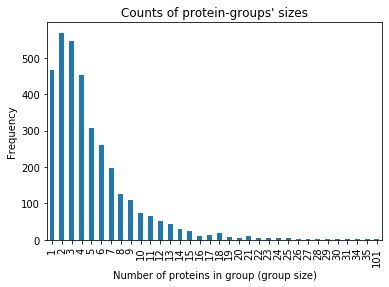

In [29]:
ax = run_protein["Number of proteins"].value_counts().sort_index().plot(kind='bar', title='Counts of protein-groups\' sizes')
ax.set_xlabel('Number of proteins in group (group size)')
ax.set_ylabel('Frequency')

In [30]:
protein_index = run_protein["Protein IDs"].str.split(';').apply(set)
protein_index.apply(len).sum()

17257

In [31]:
protein_index.apply(len)

0        5
1        9
2        3
3        7
4       21
        ..
3425     2
3426     1
3427     3
3428     1
3429     8
Name: Protein IDs, Length: 3430, dtype: int64

In [32]:
protein_index_set = set()
for _set in protein_index:
    protein_index_set = protein_index_set.union(_set)
len(protein_index_set)

17257

Unique entries

### Load Protein Intensities
- by all proteins
- by majority proteins

In [33]:
dtypes_proteins = run_protein.dtypes.to_dict()
dtypes_proteins

{'Protein IDs': dtype('O'),
 'Majority protein IDs': dtype('O'),
 'Peptide counts (all)': dtype('O'),
 'Peptide counts (razor+unique)': dtype('O'),
 'Peptide counts (unique)': dtype('O'),
 'Protein names': dtype('O'),
 'Gene names': dtype('O'),
 'Fasta headers': dtype('O'),
 'Number of proteins': dtype('int64'),
 'Peptides': dtype('int64'),
 'Razor + unique peptides': dtype('int64'),
 'Unique peptides': dtype('int64'),
 'Sequence coverage [%]': dtype('float64'),
 'Unique + razor sequence coverage [%]': dtype('float64'),
 'Unique sequence coverage [%]': dtype('float64'),
 'Mol. weight [kDa]': dtype('float64'),
 'Sequence length': dtype('int64'),
 'Sequence lengths': dtype('O'),
 'Q-value': dtype('float64'),
 'Score': dtype('float64'),
 'Intensity': dtype('int64'),
 'MS/MS count': dtype('int64'),
 'Only identified by site': dtype('O'),
 'Reverse': dtype('O'),
 'Potential contaminant': dtype('O'),
 'id': dtype('int64'),
 'Peptide IDs': dtype('O'),
 'Peptide is razor': dtype('O'),
 'Mod. p

In [34]:
load_protein_intensities??

Signature: load_protein_intensities(filepath)
Source:   
def load_protein_intensities(filepath):
    """Load Intensities from `proteins.txt`."""
    df = pd.read_table(filepath, index_col='Majority protein IDs', dtype=dtypes_proteins)
    return df[['Intensity']]
File:      c:\users\kzl465\documents\vaep\project\src\file_utils.py
Type:      function


In [35]:
proteins, col_names, failed = process_files(handler_fct=load_protein_intensities, filepaths=paths_proteins[:20]) 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.25it/s]


In [36]:
proteins.columns = col_names

In [37]:
proteins

,MQ1.6.0.1_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_200327,MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_200330,MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_20190104110509_200331,MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_02_200331
Majority protein IDs,,,,
A0A024QZP7;P06493-2;P06493;A0A087WZZ9;E5RIU6,nan,nan,nan,"489,600,000"
A0A024QZP7;P06493;A0A087WZZ9;E5RIU6;P06493-2,nan,"523,870,000","2,030,700,000",nan
A0A024QZP7;P06493;A0A087WZZ9;P06493-2;E5RIU6,"523,870,000",nan,nan,nan
A0A024QZX5;A0A087X1N8;P35237;A0A2R8YD12,nan,nan,nan,"1,312,500,000"
A0A024QZX5;A0A087X1N8;P35237;A0A2R8YD12;A0A2R8Y6A7,nan,nan,"1,545,800,000",nan
...,...,...,...,...
X6RLT1;H0UI80;Q8IXH7-4;Q8IXH7,nan,nan,"107,280,000","91,458,000"
X6RM00;G8JLD3;X6RLX0;Q8IUD2-4;Q8IUD2-2;Q8IUD2-3;Q8IUD2;Q8IUD2-5,"146,540,000","146,540,000",nan,"187,180,000"
X6RM00;G8JLD3;X6RLX0;Q8IUD2-4;Q8IUD2-2;Q8IUD2-3;Q8IUD2;Q8IUD2-5;K7EPD6;A0A0U1RQN0,nan,nan,"103,780,000",nan


In [38]:
proteins.isna().sum()

MQ1.6.0.1_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_200327                    4082
MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_200330                   4165
MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_20190104110509_200331    3765
MQ1.6.1.12_20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_02_200331                   3899
dtype: int64

## Verify: ~500 proteins have no unique peptides
Theoretical analysis has established that roughly ~500 out of the ~20000 human proteins have no unique peptides using trypsin as protease. 

- ask Marie

## Theoretial Peptides from used fasta-file